In [1]:
# code modified from here:
# https://github.com/twitterdev/Twitter-API-v2-sample-code/blob/main/Full-Archive-Tweet-Counts/full_archive_tweet_counts.py

import os
import json
import numpy as np
import pandas as pd
import time
import matplotlib.pylab as plt
import datetime
import seaborn as sns

In [94]:
savefig_settings = {'bbox_inches': 'tight', 'facecolor': 'w', 'dpi': 150}
idx = pd.IndexSlice

## results of automatic labeling

In [2]:
tweets_classified_df = pd.read_csv("../classifier/tweets_classified4_annotated.csv", index_col=0)
print(len(tweets_classified_df))

1467983


In [3]:
# convert created_at to pd time object
def convert_str_to_datetime(datetime_string):
    return datetime.datetime.strptime(datetime_string ,"%Y-%m-%dT%H:%M:%S.%fZ")

tweets_classified_df['created_at'] = tweets_classified_df['created_at'].apply(convert_str_to_datetime)

In [11]:
# aggregate category labels

keywords_df = pd.read_csv("../data-download/Geoengineering keywords for Twitter query - review.csv", header=[1])
keywords_filtered = keywords_df[keywords_df["action after second update"] == "keep"]
subquery_ids = keywords_filtered["subquery_id"].values

for cat in keywords_filtered['category'].unique():
    print(cat)
    sids = keywords_filtered[keywords_filtered['category'] == cat]["subquery_id"].values
    tweets_classified_df[cat] = (tweets_classified_df[sids].sum(axis=1) > 0).map({True: 1, False: 0})

General
SRM
GGR


In [ ]:
tweets_classified_df.head()

In [ ]:
tweets_classified_df.columns

In [6]:
# count retweets, replies, likes, quotes

tweets_classified_df[['retweet_count', 'reply_count', 'like_count', 'quote_count']].sum()

retweet_count    1924166
reply_count       461766
like_count       4268598
quote_count       192376
dtype: int64

In [7]:
tweets_classified_df[['retweet_count', 'reply_count', 'like_count', 'quote_count']].sum() / len(tweets_classified_df)

retweet_count    1.310755
reply_count      0.314558
like_count       2.907798
quote_count      0.131048
dtype: float64

In [5]:
# export random sample for cross checking

ids = np.random.choice(len(tweets_classified_df), 100, replace=False)

In [6]:
tweets_classified_df.loc[ids].to_csv("../classifier/tweets_classified_random_sample100.csv")

In [7]:
# check counts
tweets_classified_df["cardiff-sentiment"].value_counts()

neutral     931686
negative    338337
positive    197960
Name: cardiff-sentiment, dtype: int64

In [8]:
tweets_classified_df["cardiff-emotion"].value_counts()

optimism    579827
anger       386030
sadness     306153
joy         195973
Name: cardiff-emotion, dtype: int64

In [9]:
tweets_classified_df["geomotions-ekman"].value_counts() #.plot.bar()

neutral     1174550
joy          185387
surprise      56472
anger         34105
fear           8547
sadness        7434
disgust        1488
Name: geomotions-ekman, dtype: int64

In [10]:
tweets_classified_df["geomotions-orig"].value_counts()

surprise          1123856
approval            64845
admiration          43558
curiosity           33793
neutral             26889
confusion           25457
disapproval         21612
annoyance           20757
gratitude           19005
pride               14195
caring              11081
disappointment       8950
sadness              7641
fear                 6928
anger                6447
desire               6284
excitement           6193
love                 4617
amusement            4420
joy                  2920
remorse              2729
disgust              1904
relief               1316
optimism             1073
nervousness           716
embarrassment         610
realization           186
grief                   1
Name: geomotions-orig, dtype: int64

In [11]:
tweets_classified_df["bertweet-emotions"].value_counts()

others      1236294
disgust      109933
joy           49429
fear          39790
anger         24782
surprise       5553
sadness        2202
Name: bertweet-emotions, dtype: int64

In [12]:
tweets_classified_df["nrc-highest"].value_counts()

neutral         574070
positive        282606
negative        183802
fear            176264
trust           158295
anger            39863
anticipation     31534
surprise         13952
sadness           6894
disgust            605
joy                 98
Name: nrc-highest, dtype: int64

In [13]:
tweets_classified_df["nrc"].isna().sum()

574070

<AxesSubplot:>

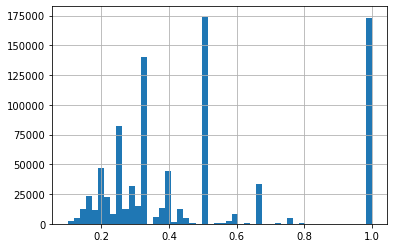

In [14]:
tweets_classified_df["nrc-score"].hist(bins=50)

In [15]:
# compare to counts by tim for consistency -> checked!
count_dict_tim = {'cardiff-stance-climate': {'none': 401220, 'favor': 1066763}, 
 'cardiff-offensive': {'offensive': 44852, 'not-offensive': 1423131},
 'cardiff-sentiment': {'negative': 338337, 'neutral': 931686, 'positive': 197960},
 'bertweet-sentiment': {'negative': 376438, 'neutral': 896848, 'positive': 194697},
 'geomotions-orig': {'surprise': 1123856, 'confusion': 25457, 'curiosity': 33793, 'fear': 6928, 'disgust': 1904, 'gratitude': 19005, 'excitement': 6193, 'approval': 64845, 'anger': 6447, 'admiration': 43558, 'disappointment': 8950, 'remorse': 2729, 'neutral': 26889, 'amusement': 4420, 'desire': 6284, 'caring': 11081, 'annoyance': 20757, 'disapproval': 21612, 'sadness': 7641, 'embarrassment': 610, 'love': 4617, 'nervousness': 716, 'joy': 2920, 'pride': 14195, 'relief': 1316, 'optimism': 1073, 'realization': 186, 'grief': 1},
 'geomotions-ekman': {'neutral': 1174550, 'fear': 8547, 'joy': 185387, 'disgust': 1488, 'surprise': 56472, 'anger': 34105, 'sadness': 7434},
 'cardiff-emotion': {'anger': 386030, 'sadness': 306153, 'optimism': 579827, 'joy': 195973},
 'bertweet-emotions': {'anger': 24782, 'others': 1236294, 'disgust': 109933, 'fear': 39790, 'joy': 49429, 'sadness': 2202, 'surprise': 5553},
 'nrc': {'fear': 327889, 'anger': 238695, 'negative': 562795, 'sadness': 259782, 'disgust': 185412, 'anticipation': 329305, 'positive': 593580, 'trust': 403964, 'joy': 222798, 'surprise': 161042}
 }

In [16]:
for key in count_dict_tim:
    print(key)
    labels = count_dict_tim[key]
    counter = 0
    for label in labels:
        counter += labels[label]
    print(counter)

cardiff-stance-climate
1467983
cardiff-offensive
1467983
cardiff-sentiment
1467983
bertweet-sentiment
1467983
geomotions-orig
1467983
geomotions-ekman
1467983
cardiff-emotion
1467983
bertweet-emotions
1467983
nrc
3285262


## map high dimensional emotions

In [5]:
tweets_classified_df['geomotions-ekman-tertiary'] = tweets_classified_df['geomotions-ekman'].map({'neutral': 'neutral',
                                               'joy': 'positive',
                                                'surprise': 'neutral',
                                                'anger': 'negative',
                                                'fear': 'negative',
                                                'sadness': 'negative',
                                                'disgust': 'negative'})

In [6]:
tweets_classified_df['cardiff-emotion-tertiary'] = tweets_classified_df['cardiff-emotion'].map({
'optimism': 'neutral',
'anger': 'negative',
'sadness': 'negative',
'joy': 'positive'
})

In [7]:
tweets_classified_df["nrc-highest-tertiary"] = tweets_classified_df["nrc-highest"].map({
'neutral': 'neutral',
'positive': 'positive',
'negative': 'negative',
'fear': 'negative',
'trust': 'positive',
'anger': 'negative',
'anticipation': 'positive',
'surprise': 'neutral',
'sadness': 'negative',
'disgust': 'negative',
'joy': 'positive'
})

In [8]:
tweets_classified_df["bertweet-emotions-tertiary"] = tweets_classified_df["bertweet-emotions"].map({
'others': 'neutral',
'disgust': 'negative',
'joy': 'positive',
'fear': 'negative',
'anger': 'negative',
'surprise': 'neutral',
'sadness': 'negative'})

In [12]:
# compare: cardiff-sentiment, bertweet-sentiment, geomotions-ekman,
# cardiff-emotion, bertweet-emotions, nrc-

In [13]:
tweets_classified_df[['cardiff-sentiment', 'bertweet-sentiment', 'nrc-highest-tertiary',
'cardiff-emotion-tertiary', 'geomotions-ekman-tertiary', 'bertweet-emotions-tertiary']]

cardiff-sentiment bertweet-sentiment nrc-highest-tertiary  \
lid                                                                 
1                negative           negative             negative   
2                 neutral           negative              neutral   
3                negative            neutral             positive   
4                negative           negative             negative   
5                negative           negative             negative   
...                   ...                ...                  ...   
1467979           neutral            neutral             negative   
1467980           neutral            neutral             positive   
1467981           neutral            neutral              neutral   
1467982          positive            neutral             positive   
1467983           neutral            neutral             positive   

        cardiff-emotion-tertiary geomotions-ekman-tertiary  \
lid                                                          
1                       negative                   neutral   
2                       negative                   neutral   
3                       negative                   neutral   
4                       negative                   neutral   
5                       negative                   neutral   
...                          ...                       ...   
1467979                  neutral                   neutral   
1467980                  neutral                   neutral   
1467981                 negative                   neutral   
1467982                  neutral                   neutral   
1467983                  neutral                  positive   

        bertweet-emotions-tertiary  
lid                                 
1                         negative  
2                          neutral  
3                         negative  
4                         negative  
5                         negative  
...                            ...  
1467979                    neutral  
1467980                    neutral  
1467981                    neutral  
1467982                    neutral  
1467983                    neutral  

[1467983 rows x 6 columns]

## compare different classifiers

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import itertools

In [26]:
classifiers = ['cardiff-sentiment', 'bertweet-sentiment', 'nrc-highest-tertiary',
'cardiff-emotion-tertiary', 'geomotions-ekman-tertiary', 'bertweet-emotions-tertiary']
pairs = list(itertools.combinations(classifiers, 2))

cardiff-sentiment bertweet-sentiment
cardiff-sentiment nrc-highest-tertiary
cardiff-sentiment cardiff-emotion-tertiary
cardiff-sentiment geomotions-ekman-tertiary
cardiff-sentiment bertweet-emotions-tertiary
bertweet-sentiment nrc-highest-tertiary
bertweet-sentiment cardiff-emotion-tertiary
bertweet-sentiment geomotions-ekman-tertiary
bertweet-sentiment bertweet-emotions-tertiary
nrc-highest-tertiary cardiff-emotion-tertiary
nrc-highest-tertiary geomotions-ekman-tertiary
nrc-highest-tertiary bertweet-emotions-tertiary
cardiff-emotion-tertiary geomotions-ekman-tertiary
cardiff-emotion-tertiary bertweet-emotions-tertiary
geomotions-ekman-tertiary bertweet-emotions-tertiary


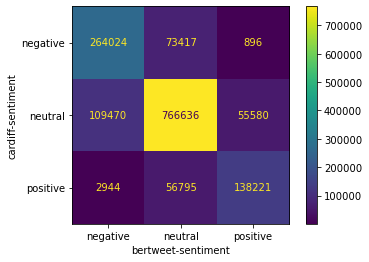

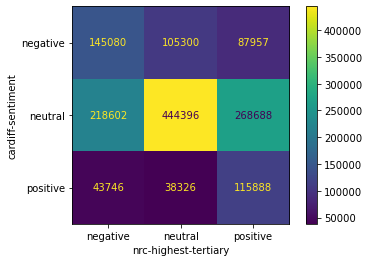

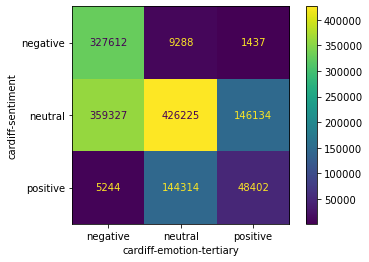

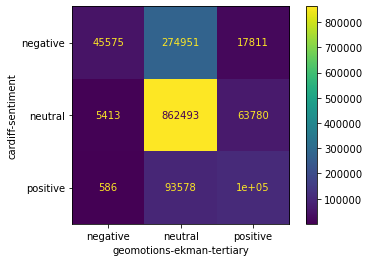

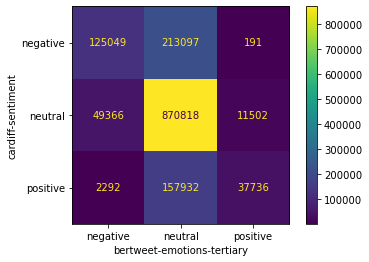

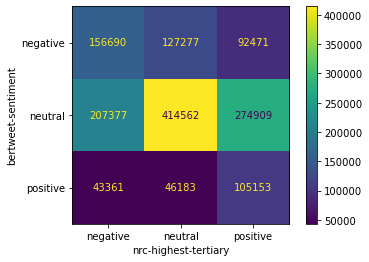

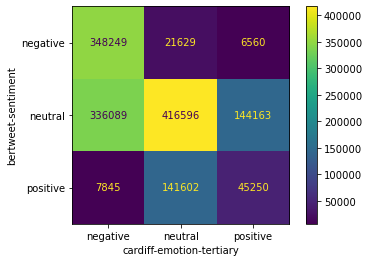

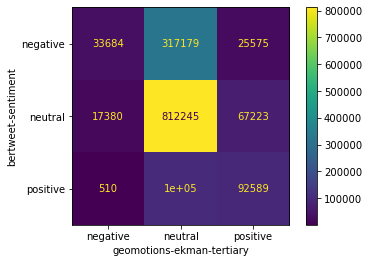

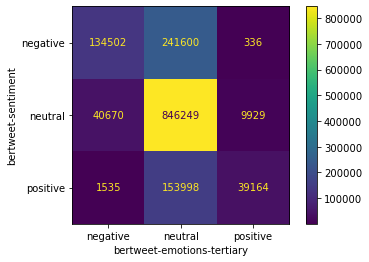

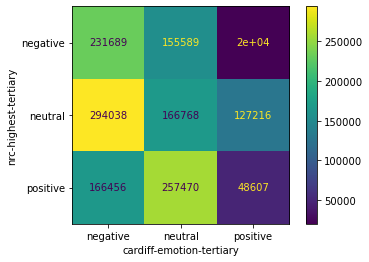

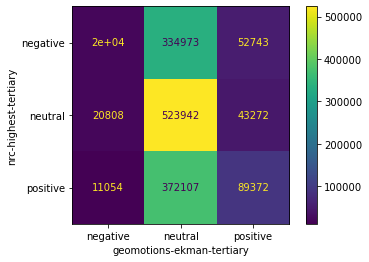

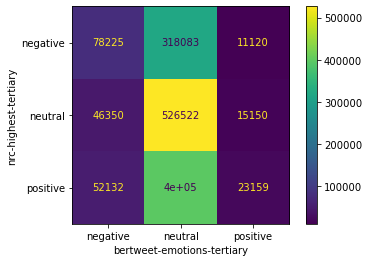

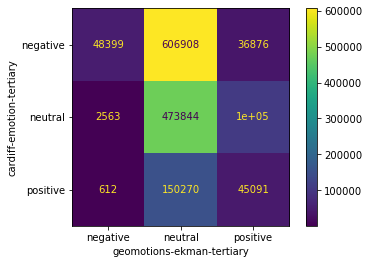

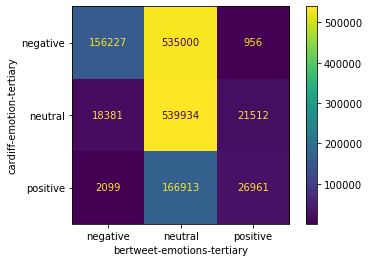

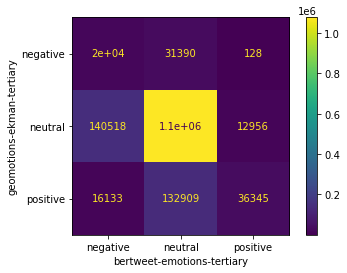

In [27]:
#pairs = ['cardiff-sentiment', 'bertweet-sentiment']

for classifier1, classifier2 in pairs:
    print(classifier1, classifier2)

    labels = np.sort(tweets_classified_df[classifier1].unique())
    cm = confusion_matrix(tweets_classified_df[classifier1],
                          tweets_classified_df[classifier2],
                          labels=labels)

    disp = ConfusionMatrixDisplay(cm, display_labels=labels)
    disp.plot()
    plt.xlabel(classifier2)
    plt.ylabel(classifier1)
    plt.savefig("figures/comparison_matrix_{}-{}.png".format(classifier1, classifier2), **savefig_settings)

## compare with human annotation

In [107]:
files = ["../labeling/intercoder comparison_sample1.xlsx",
         "../labeling/intercoder comparison_sample2.xlsx",
         "../labeling/intercoder comparison_srm_sample.xlsx",
         "../labeling/intercoder comparison_ggr_sample.xlsx"]

sample_names = ["General1", "General2", "SRM", "GGR"]
dfs = []

for i, file in enumerate(files):
    temp_df = pd.read_excel(file, sheet_name="comparison")
    temp_df["sample"] = sample_names[i]
    dfs.append(temp_df)
    
an = pd.concat(dfs)

In [108]:
print(len(an))
an = an[~an["tweet__id"].isna()]
print(len(an))
an.head()

6091
6086


tweet__id                                        tweet__text  \
0  9.504236e+17  Geoengineering Watch Global Alert News, Januar...   
1  9.504236e+17  Geoengineering Watch Global Alert News, Januar...   
2  9.504236e+17  Geoengineering Watch Global Alert News, Januar...   
3  9.504236e+17  Geoengineering Watch Global Alert News, Januar...   
4  9.504236e+17  Geoengineering Watch Global Alert News, Januar...   

    tweet__created_at Category Name  SeanLow  brutschin@iiasa.ac.at  \
0 2018-01-08 17:47:01  0 - relevant      NaN                    NaN   
1 2018-01-08 17:47:01  2 - Negative      NaN                    NaN   
2 2018-01-08 17:47:01   2 - Neutral      NaN                    NaN   
3 2018-01-08 17:47:01  2 - Positive      NaN                    NaN   
4 2018-01-08 17:47:01     3 - Anger      NaN                    NaN   

   cmbaum@btech.au.dk  galm  lueck@mcc-berlin.net  muef  ...  average  \
0                 NaN   1.0                   NaN   1.0  ...      NaN   
1                 NaN   0.0                   NaN   1.0  ...      NaN   
2                 NaN   1.0                   NaN   0.0  ...      NaN   
3                 NaN   0.0                   NaN   0.0  ...      NaN   
4                 NaN   0.0                   NaN   0.0  ...      NaN   

   sentiment sentiment.1  sentiment.2  emotion  emotion.1  emotion.2  stance  \
0        NaN         NaN          NaN      NaN        NaN        NaN     NaN   
1        NaN         NaN          NaN      NaN        NaN        NaN     NaN   
2        NaN         NaN          NaN      NaN        NaN        NaN     NaN   
3        NaN         NaN          NaN      NaN        NaN        NaN     NaN   
4        NaN         NaN          NaN      NaN        NaN        NaN     NaN   

   stance.1  stance.2  
0       NaN       NaN  
1       NaN       NaN  
2       NaN       NaN  
3       NaN       NaN  
4       NaN       NaN  

[5 rows x 24 columns]

<AxesSubplot:>

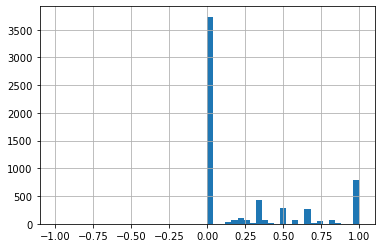

In [109]:
# aggregate labels

users = [user for user in  ["SeanLow", "brutschin@iiasa.ac.at", "galm",
                                              "jcroberts4@wisc.edu", "lueck@mcc-berlin.net",
                                              "muef", "repke@mcc-berlin.net"] if user in an.columns]
an["average"] = an[users].mean(axis=1)
an["average"].hist(bins=50)

In [110]:
annotation_dict = {'annotated-relevant': ['0 - relevant'],
                   'annotated-sentiment': ['2 - Negative', '2 - Neutral', '2 - Positive'],
       'annotated-emotion': ['3 - Anger', '3 - Disgust', '3 - Fear', '3 - Joy',
       '3 - Other or none', '3 - Sadness', '3 - Surprise'],
       'annotated-stance': ['4 - Contra','4 - Neutral', '4 - Pro'],
       'annotated-conspiracy': ['5 - Yes'],
       'annotated-spam': ['6 - Yes']}

In [111]:
for annotation in annotation_dict:
    an[annotation] = '' #np.nan
    for label in annotation_dict[annotation]:
        an.loc[(an["average"] > 0.5) & (an['Category Name'] == label), annotation] = label

In [112]:
#an[~an["annotated-sentiment"].isna()]

In [113]:
agg = []

for annotation in list(annotation_dict.keys()):
    agg.append(an.groupby('tweet__id')[annotation].aggregate(lambda x: ''.join(x)))

agg.append(an.set_index('tweet__id')["tweet__text"].drop_duplicates())
agg.append(an.drop_duplicates(subset=['tweet__id', 'sample']).set_index('tweet__id')["sample"])

agg = pd.concat(agg, axis=1)

In [114]:
for annotation in list(annotation_dict.keys()):
    print(agg[annotation].value_counts())

0 - relevant    359
                 40
Name: annotated-relevant, dtype: int64
                174
2 - Negative    117
2 - Neutral      87
2 - Positive     21
Name: annotated-sentiment, dtype: int64
3 - Other or none       243
                         98
3 - Anger                22
3 - Fear                 18
3 - Surprise              4
3 - Anger3 - Disgust      4
3 - Anger3 - Fear         4
3 - Joy                   3
3 - Disgust               3
Name: annotated-emotion, dtype: int64
               162
4 - Contra     138
4 - Neutral     68
4 - Pro         31
Name: annotated-stance, dtype: int64
           272
5 - Yes    127
Name: annotated-conspiracy, dtype: int64
    399
Name: annotated-spam, dtype: int64


In [115]:
agg['annotated-emotion-tertiary'] = agg['annotated-emotion'].map({'3 - Other or none': 'neutral',
                                       '': 'no agreement',
                                       '3 - Anger': 'negative',
                                       '3 - Fear': 'negative',
                                       '3 - Surprise': 'neutral',
                                       '3 - Anger3 - Disgust': 'negative',
                                       '3 - Anger3 - Fear': 'negative',
                                       '3 - Joy': 'positive',
                                       '3 - Disgust': 'negative'})
agg['annotated-emotion-tertiary'].value_counts()

neutral         247
no agreement     98
negative         51
positive          3
Name: annotated-emotion-tertiary, dtype: int64

In [116]:
agg = agg.reset_index()
agg["tweet__id"] = agg["tweet__id"].astype(int)

In [117]:
merged_an = pd.merge(tweets_classified_df, agg.reset_index(),
            left_on='tid',
            right_on='tweet__id',
            how='inner')
print(len(merged_an))

13


In [118]:
merged_an['text identical'] = (merged_an['text'] == merged_an['tweet__text'])

In [119]:
merged_an[['tid', 'text', 'tweet__id', 'tweet__text', 'text identical']]

tid                                               text  \
0   1297911818237521920  Solar Forcing  Geoengineering  Storm Alerts | ...   
1   1225242579014320128  @quasimodem1951 @DawnTJ90 Am I the first one t...   
2   1103819030270337024  @united @Delta @WestJet you are criminals spra...   
3    990245563764477952  #Enjoy the #blueskies while you can this #Satu...   
4    980646113354031104  @SkyWeatherAUS WATCH &amp; Understand What You...   
5    957045355463426048  The engineers are painting our sky white. #che...   
6    955534378733654016  If we start deliberately cooling the Earth  we...   
7    950423612636450816  Geoengineering Watch Global Alert News  Januar...   
8   1208894596152999936  @LionelMedia Idiots will call Chemtrails a con...   
9   1419183131031130112  The potential solution to global warming? It c...   
10  1241717934348795904  Solar geoengineering involves directly cooling...   
11  1259543046699520000  @RokJohannes I believe it was BRENNAN in an in...   
12  1156332376634449920  Wetlands bury carbon. They'll store more 'blue...   

              tweet__id                                        tweet__text  \
0   1297911818237521920  Solar Forcing, Geoengineering, Storm Alerts | ...   
1   1225242579014320128  Am I the first one then? By the way...it's cal...   
2   1103819030270337024  @united @Delta @WestJet you are criminals spra...   
3    990245563764477952  #Enjoy the #blueskies while you can this #Satu...   
4    980646113354031104  @SkyWeatherAUS WATCH &amp; Understand What You...   
5    957045355463426048  The engineers are painting our sky white. #che...   
6    955534378733654016  If we start deliberately cooling the Earth, we...   
7    950423612636450816  Geoengineering Watch Global Alert News, Januar...   
8   1208894596152999936  @LionelMedia Idiots will call Chemtrails a con...   
9   1419183131031130112  The potential solution to global warming? It c...   
10  1241717934348795904  Solar geoengineering involves directly cooling...   
11  1259543046699520000  @RokJohannes I believe it was BRENNAN in an in...   
12  1156332376634449920  Wetlands bury carbon. They'll store more 'blue...   

    text identical  
0            False  
1            False  
2             True  
3            False  
4            False  
5             True  
6            False  
7            False  
8            False  
9            False  
10           False  
11           False  
12           False

In [120]:
# double check overlap between ids
annotated_set = set(agg['tweet__id'])
entire_set = set(tweets_classified_df['tid'])
print(len(annotated_set.intersection(entire_set)))

13


In [121]:
# todo: do fuzzy matching on text

In [122]:
sample_names

['General1', 'General2', 'SRM', 'GGR']

In [125]:
# for now, only look at frequencies for relevant

sample_name = [['General1', 'General2'], ['General1'], ['General2'], ['SRM'], ['GGR'],
               ['General1', 'General2', 'SRM', 'GGR']][5]

print(sample_name)
for annotation in list(annotation_dict.keys()):
    counts = agg[(agg['sample'].isin(sample_name)) &
                 (agg['annotated-relevant'] == '0 - relevant')][annotation].value_counts()
    print(counts.sum())
    pct = 100 * counts /counts.sum()
    print(pct)
    
    if annotation == 'annotated-emotion':
        print(pct[~pct.index.isin(["", "3 - Other or none", "3 - Surprise", "3 - Joy"])].index)
        print(pct[~pct.index.isin(["", "3 - Other or none", "3 - Surprise", "3 - Joy"])].sum())

print()

['General1', 'General2', 'SRM', 'GGR']
359
0 - relevant    100.0
Name: annotated-relevant, dtype: float64
359
                38.718663
2 - Negative    32.311978
2 - Neutral     23.119777
2 - Positive     5.849582
Name: annotated-sentiment, dtype: float64
359
3 - Other or none       63.231198
                        20.891365
3 - Anger                6.128134
3 - Fear                 4.735376
3 - Surprise             1.114206
3 - Anger3 - Disgust     1.114206
3 - Anger3 - Fear        1.114206
3 - Joy                  0.835655
3 - Disgust              0.835655
Name: annotated-emotion, dtype: float64
Index(['3 - Anger', '3 - Fear', '3 - Anger3 - Disgust', '3 - Anger3 - Fear',
       '3 - Disgust'],
      dtype='object')
13.92757660167131
359
4 - Contra     37.604457
               35.376045
4 - Neutral    18.384401
4 - Pro         8.635097
Name: annotated-stance, dtype: float64
359
           65.45961
5 - Yes    34.54039
Name: annotated-conspiracy, dtype: float64
359
    100.0
Name: anno

## plot counts by subquery or category

In [12]:
# counts by subquery

tweets_classified_df[subquery_ids].sum()

g_01    666176
g_02     53325
g_05     53214
g_06     41421
s_01     12011
         ...  
c_44     45192
c_45      7749
c_46     14822
c_47      3073
c_48       428
Length: 78, dtype: int64

In [21]:
# how many are in more than one category

sid_counts = tweets_classified_df[subquery_ids].sum(axis=1).value_counts()
print(sid_counts.sum())
sid_counts

1467983


1     1356283
2      100019
3        9427
4        1742
5         348
6          87
7          38
8          10
10         10
9           7
12          7
11          4
13          1
dtype: int64

In [22]:
print(sid_counts.sum() - sid_counts[1])
print((sid_counts.sum() - sid_counts[1])/sid_counts.sum())

111700
0.0760907994166145


In [27]:
cat_level = 'technology_category' #'technology_category' 

map_dict = {}

map_dict_reverse = {}

for cat in keywords_filtered[cat_level].unique():
    sids = keywords_filtered[keywords_filtered[cat_level] == cat]["subquery_id"].values
    map_dict[cat] = list(sids)
    for sid in sids:
        map_dict_reverse[sid] = cat

#print(json.dumps(map_dict))
#print(json.dumps(map_dict_reverse))

In [28]:
count_tweets = tweets_classified_df[subquery_ids].sum()

count_dict = {}

for cl in map_dict:
    count_dict[cl] = count_tweets[map_dict[cl]].sum()
print(count_dict)

{'Geoengineering (general)': 814136, 'SRM (general)': 37394, 'aerosol injection': 12295, 'cloud brightening': 4236, 'surface albedo modification': 1627, 'cloud thinning': 238, 'space shades': 755, 'GGR (general)': 146000, 'CCS': 206913, 'methane removal': 3548, 'ocean fertilization': 8771, 'enhanced weathering': 7867, 'biochar': 19312, 'afforestation and reforestation': 83665, 'ecosystem restoration': 19808, 'Soil carbon sequestration': 99073, 'BECCS': 23283, 'blue carbon': 79489, 'direct air capture': 26072}


In [33]:
print(len(count_dict))
count_df = pd.Series(count_dict).to_frame()
count_df['pct_of_total'] = 100*count_df[0] / count_df[0].sum()
count_df

19


0  pct_of_total
Geoengineering (general)         814136     51.059592
SRM (general)                     37394      2.345213
aerosol injection                 12295      0.771097
cloud brightening                  4236      0.265666
surface albedo modification        1627      0.102039
cloud thinning                      238      0.014926
space shades                        755      0.047351
GGR (general)                    146000      9.156579
CCS                              206913     12.976816
methane removal                    3548      0.222517
ocean fertilization                8771      0.550085
enhanced weathering                7867      0.493389
biochar                           19312      1.211177
afforestation and reforestation   83665      5.247159
ecosystem restoration             19808      1.242284
Soil carbon sequestration         99073      6.213491
BECCS                             23283      1.460223
blue carbon                       79489      4.985255
direct air capture                26072      1.635139

In [36]:
# SRM
count_df.iloc[1:7] / count_df.iloc[1:7].sum()

0  pct_of_total
SRM (general)                0.661314      0.661314
aerosol injection            0.217437      0.217437
cloud brightening            0.074914      0.074914
surface albedo modification  0.028774      0.028774
cloud thinning               0.004209      0.004209
space shades                 0.013352      0.013352

In [41]:
# SRM
(count_df.iloc[7:] / count_df.iloc[7:].sum()).sort_values(0, ascending=False)

0  pct_of_total
CCS                              0.285870      0.285870
GGR (general)                    0.201713      0.201713
Soil carbon sequestration        0.136879      0.136879
afforestation and reforestation  0.115591      0.115591
blue carbon                      0.109822      0.109822
direct air capture               0.036021      0.036021
BECCS                            0.032168      0.032168
ecosystem restoration            0.027367      0.027367
biochar                          0.026681      0.026681
ocean fertilization              0.012118      0.012118
enhanced weathering              0.010869      0.010869
methane removal                  0.004902      0.004902

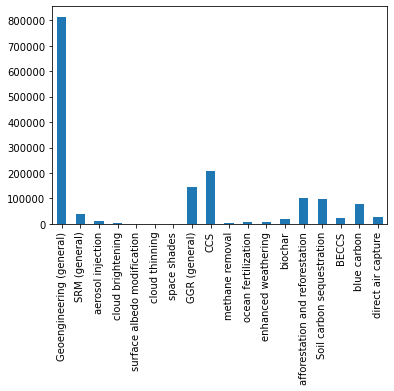

In [274]:
pd.Series(count_dict).plot.bar()
plt.savefig('figures/counts_technology_category.png', **savefig_settings)

## plot label counts by category

cardiff-sentiment
bertweet-sentiment
nrc-highest-tertiary
cardiff-emotion-tertiary
geomotions-ekman-tertiary
bertweet-emotions-tertiary
conspiracy-filter


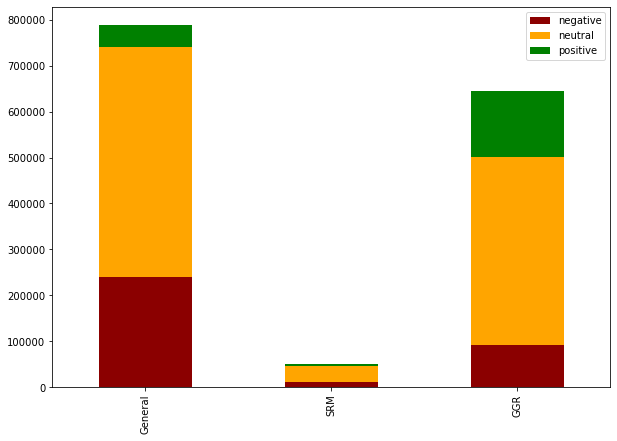

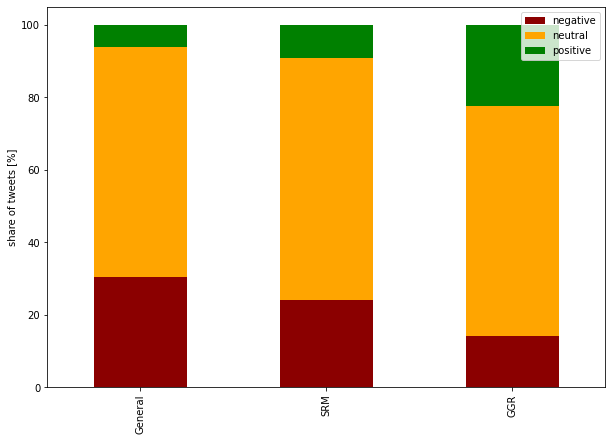

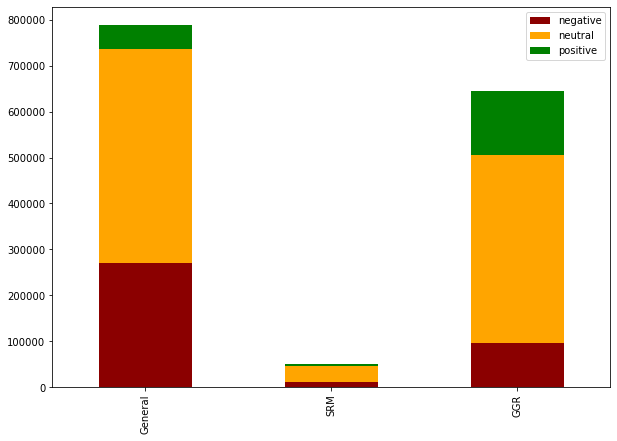

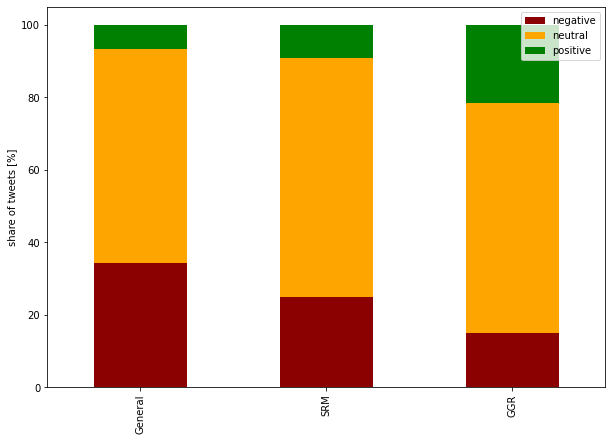

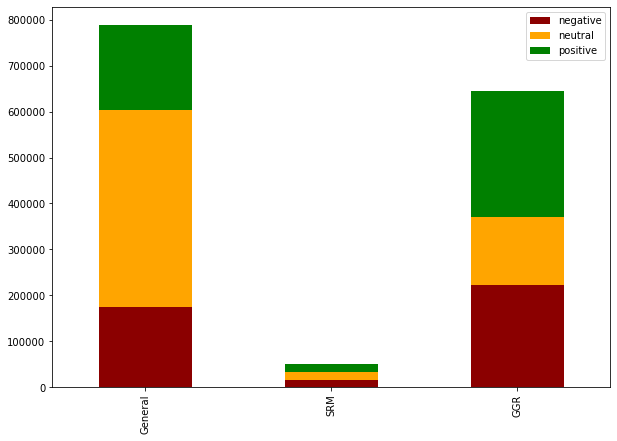

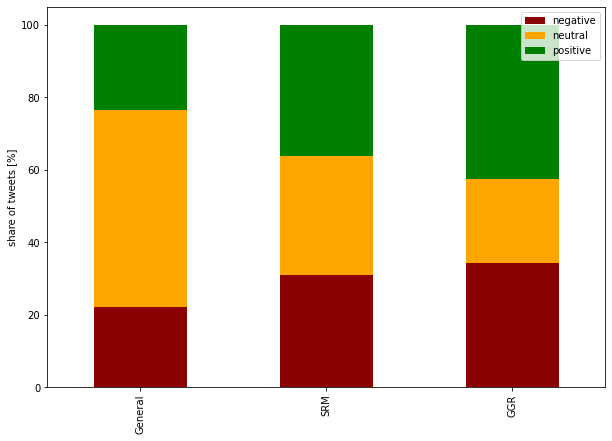

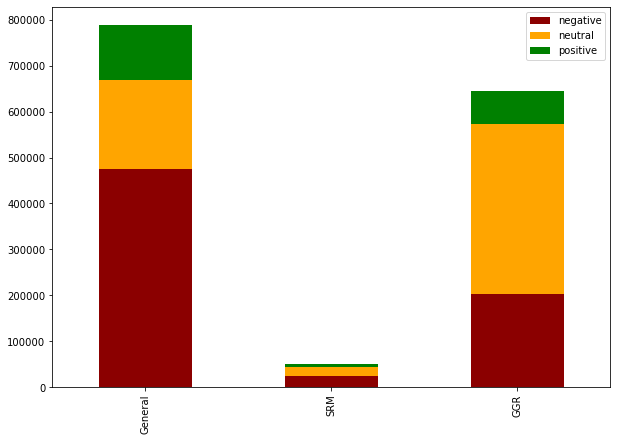

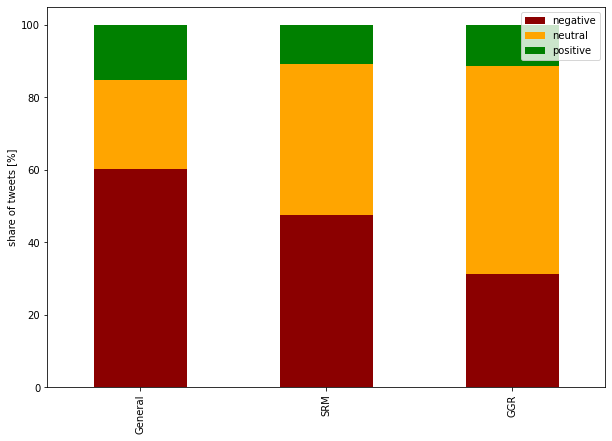

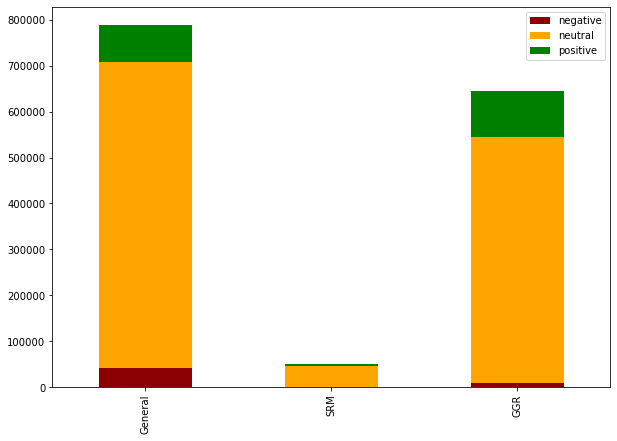

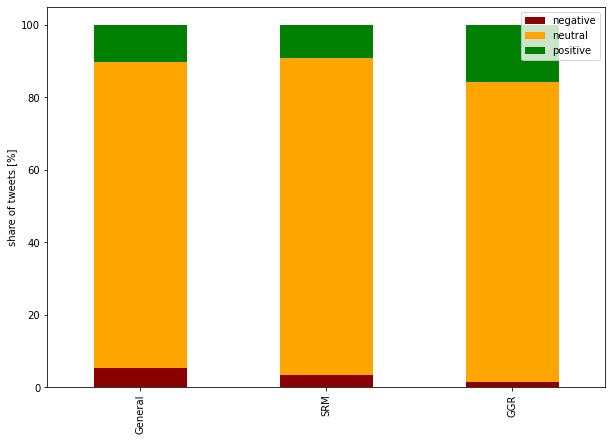

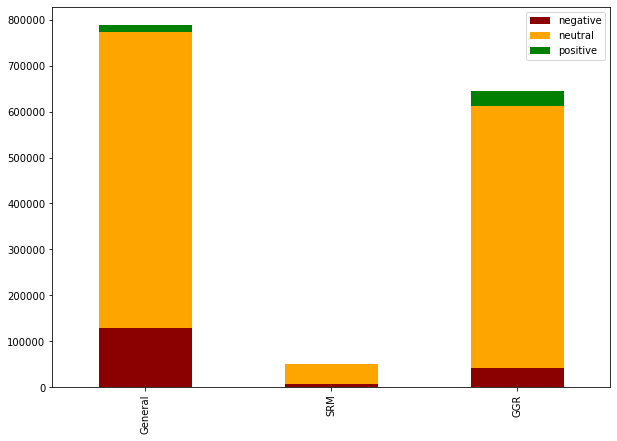

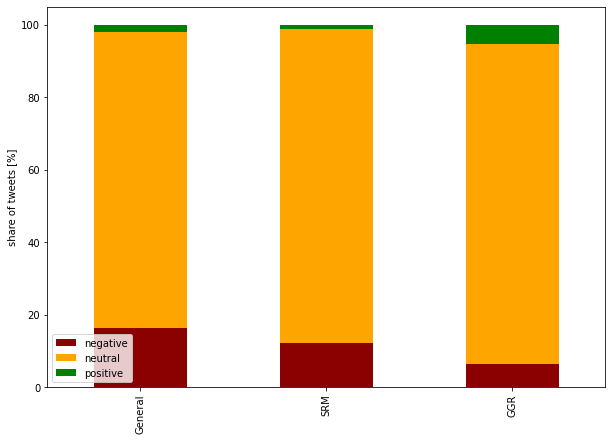

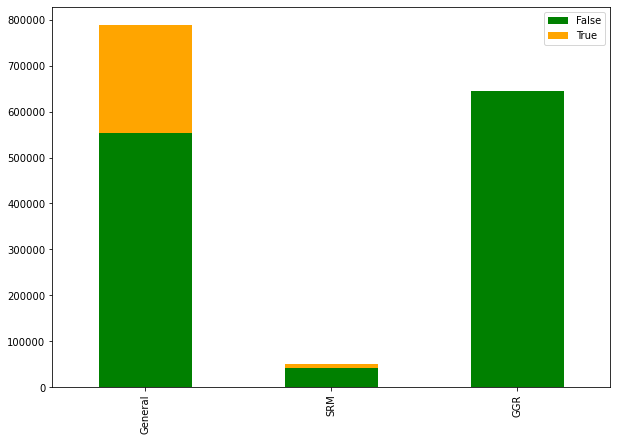

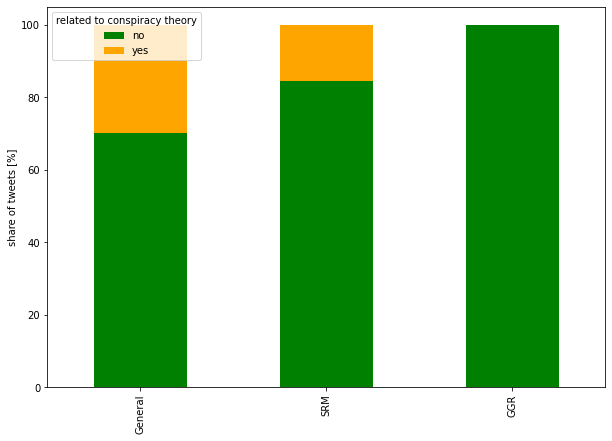

In [96]:
# counts by category

cat_level = 'category'
#cat_level = 'technology_category' #  'category' or 'technology_category' or 'subquery_id'

value_counts = {}
all_class_counts = {}
all_class_shares = {}

for classifier_name in ['cardiff-sentiment', 'bertweet-sentiment', 'nrc-highest-tertiary',
'cardiff-emotion-tertiary', 'geomotions-ekman-tertiary', 'bertweet-emotions-tertiary', 'conspiracy-filter']:
    
    print(classifier_name)
    for cat in keywords_filtered[cat_level].unique():
        sids = keywords_filtered[keywords_filtered[cat_level] == cat]["subquery_id"].values
        #print(cat, sids)
        value_counts[cat] = tweets_classified_df[tweets_classified_df[sids].sum(axis=1) > 0][classifier_name].value_counts()

    class_counts = pd.DataFrame(value_counts).sort_index()
    all_class_counts[classifier_name] = class_counts
    
    class_shares = 100 * (class_counts / class_counts.sum())
    all_class_shares[classifier_name] = class_shares
    
    if classifier_name == 'conspiracy-filter':
        color = ['g', 'orange']
    else:
        color = ['darkred', 'orange', 'g']
    
    fig, ax = plt.subplots(figsize=(10,7))
    class_counts.transpose().plot.bar(stacked=True, ax=ax, color=color)
    fig.savefig("figures/class_counts_{}_{}.png".format(cat_level, classifier_name), **savefig_settings)
    
    fig, ax = plt.subplots(figsize=(10,7))
    class_shares.transpose().plot.bar(stacked=True, ax=ax, color=color)
    ax.set_ylabel("share of tweets [%]")
    fig.savefig("figures/class_shares_{}_{}.png".format(cat_level, classifier_name), **savefig_settings)
    
all_class_counts = pd.concat(all_class_counts)
all_class_shares = pd.concat(all_class_shares)

In [97]:
all_class_shares

General        SRM        GGR
cardiff-sentiment          negative  30.365122  24.068004  14.130164
                           neutral   63.425548  66.679172  63.369283
                           positive   6.209330   9.252824  22.500554
bertweet-sentiment         negative  34.381514  24.909170  15.053599
                           neutral   59.060340  66.017692  63.358750
                           positive   6.558146   9.073138  21.587651
nrc-highest-tertiary       negative  22.179295  31.052050  34.411500
                           neutral   54.320449  32.878525  23.121030
                           positive  23.500256  36.069426  42.467470
cardiff-emotion-tertiary   negative  60.187937  47.654214  31.380366
                           neutral   24.728022  41.683121  57.334275
                           positive  15.084040  10.662665  11.285359
geomotions-ekman-tertiary  negative   5.235283   3.362689   1.412257
                           neutral   84.589967  87.512835  82.807880
                           positive  10.174750   9.124477  15.779863
bertweet-emotions-tertiary negative  16.500606  12.151489   6.560848
                           neutral   81.525052  86.738804  88.258190
                           positive   1.974342   1.109707   5.180962
conspiracy-filter          False     70.215604  84.400916  99.876245
                           True      29.784396  15.599084   0.123755

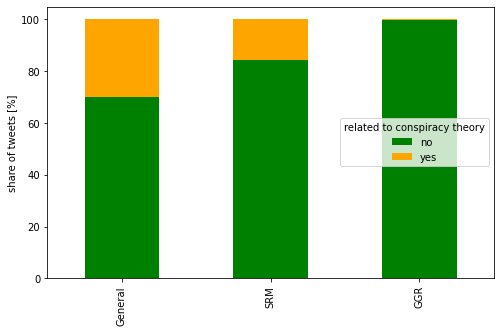

In [101]:
# plot conspiracy separately

fig, ax = plt.subplots(figsize=(8,5))
all_class_shares.loc[idx["conspiracy-filter"]].transpose().plot.bar(stacked=True, ax=ax, color=color)
ax.set_ylabel("share of tweets [%]")
plt.legend(labels=["no", "yes"], title="related to conspiracy theory", loc='center right')
fig.savefig("figures/class_shares_{}_conspiracy-filter.png".format(cat_level), **savefig_settings)

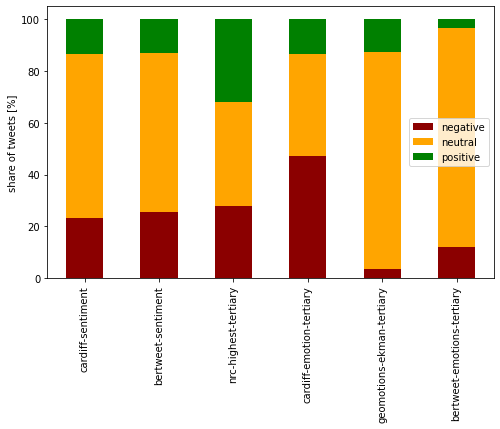

In [103]:
# plot comparison for all
color = ['darkred', 'orange', 'g']

shares_all = all_class_counts.sum(axis=1).drop("conspiracy-filter").unstack()
shares_all = 100 * shares_all.divide(shares_all.sum(axis=1), axis=0)

fig, ax = plt.subplots(figsize=(8,5))
shares_all.plot.bar(stacked=True, color=color, ax=ax)
ax.set_ylabel("share of tweets [%]")
plt.legend(loc='center right')
fig.savefig("figures/class_shares_all_models_entire_dataset.png".format(cat), **savefig_settings)

In [105]:
shares_all

negative    neutral   positive
cardiff-sentiment           23.091630  63.512049  13.396321
bertweet-sentiment          25.654957  61.166508  13.178535
nrc-highest-tertiary        27.800289  40.024109  32.175602
cardiff-emotion-tertiary    47.235352  39.483011  13.281637
geomotions-ekman-tertiary    3.509221  83.914825  12.575954
bertweet-emotions-tertiary  12.030614  84.630340   3.339046

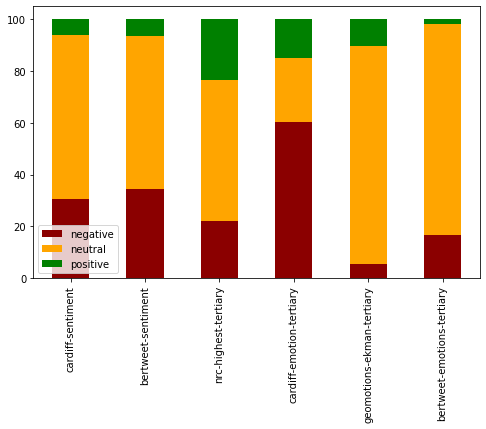

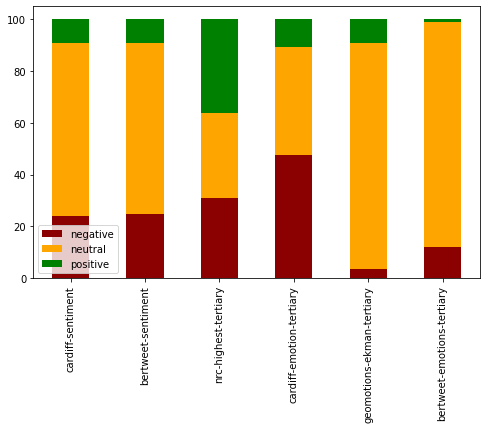

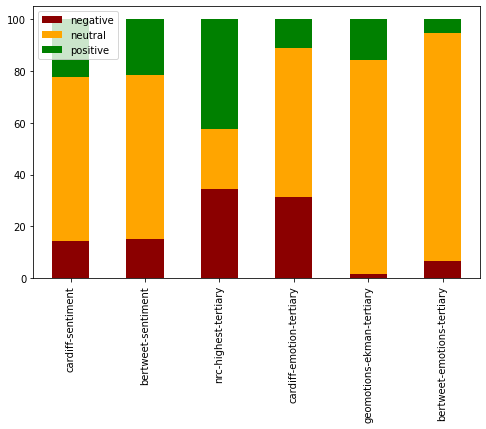

In [69]:
# plot by category

for cat in keywords_filtered[cat_level].unique():
    fig, ax = plt.subplots(figsize=(8,5))
    all_class_shares[cat].drop('conspiracy-filter').unstack().plot.bar(stacked=True, color=color, ax=ax)
    fig.savefig("figures/class_shares_all_models_{}.png".format(cat), **savefig_settings)

## look at subsets / combinations

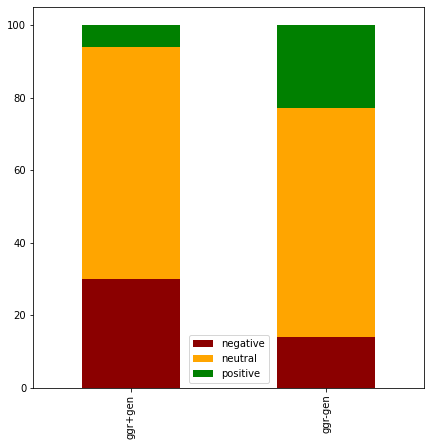

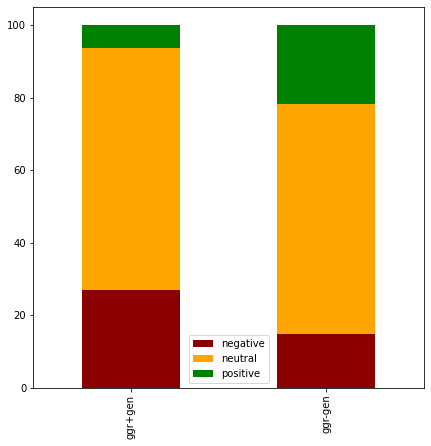

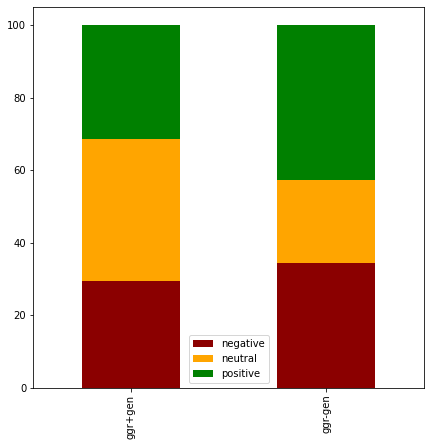

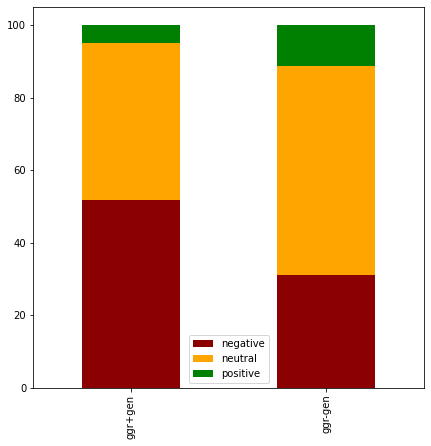

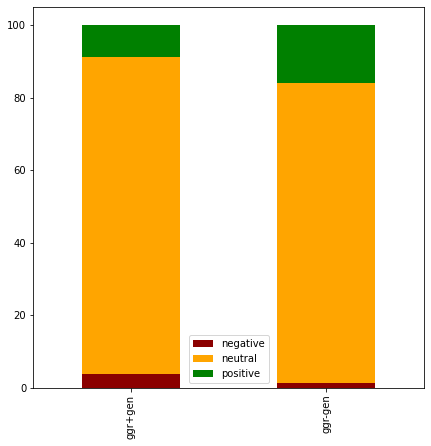

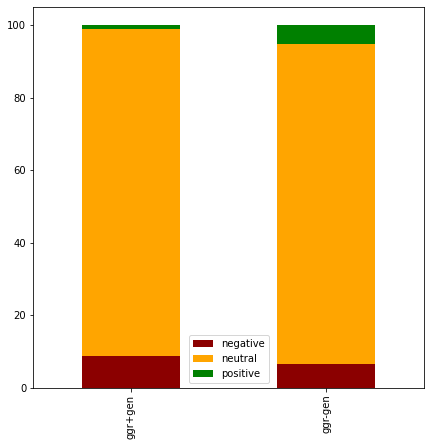

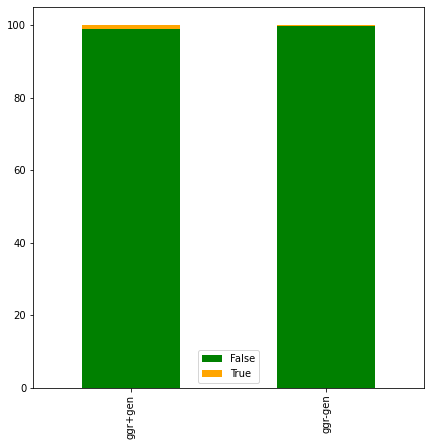

In [83]:
value_counts = {}
all_class_counts = {}
all_class_shares = {}

for classifier_name in ['cardiff-sentiment', 'bertweet-sentiment', 'nrc-highest-tertiary',
'cardiff-emotion-tertiary', 'geomotions-ekman-tertiary', 'bertweet-emotions-tertiary', 'conspiracy-filter']:

    value_counts['ggr+gen'] = tweets_classified_df[(tweets_classified_df["General"] == 1) & \
                         (tweets_classified_df["GGR"] == 1)][classifier_name].value_counts()
    value_counts['ggr-gen'] = tweets_classified_df[(tweets_classified_df["General"] == 0) & \
                         (tweets_classified_df["GGR"] == 1)][classifier_name].value_counts()
    
    class_counts = pd.DataFrame(value_counts).sort_index()
    all_class_counts[classifier_name] = class_counts
    
    class_shares = 100 * (class_counts / class_counts.sum())
    all_class_shares[classifier_name] = class_shares
    
    if classifier_name == 'conspiracy-filter':
        color = ['g', 'orange']
    else:
        color = ['darkred', 'orange', 'g']
    
    fig, ax = plt.subplots(figsize=(7,7))
    class_shares.transpose().plot.bar(stacked=True, ax=ax, color=color)
    fig.savefig("figures/class_shares_{}_{}.png".format('ggr_with_or_without', classifier_name), **savefig_settings)

all_class_counts = pd.concat(all_class_counts)
all_class_shares = pd.concat(all_class_shares)

In [84]:
all_class_shares

ggr+gen    ggr-gen
cardiff-sentiment          negative  30.031867  13.934568
                           neutral   63.849586  63.363375
                           positive   6.118547  22.702058
bertweet-sentiment         negative  26.845124  14.908559
                           neutral   66.883365  63.315396
                           positive   6.271511  21.776045
nrc-highest-tertiary       negative  29.343531  34.473838
                           neutral   39.388145  22.920939
                           positive  31.268324  42.605223
cardiff-emotion-tertiary   negative  51.727215  31.130093
                           neutral   43.288719  57.507040
                           positive   4.984066  11.362867
geomotions-ekman-tertiary  negative   3.836839   1.382434
                           neutral   87.393244  82.751479
                           positive   8.769917  15.866087
bertweet-emotions-tertiary negative   8.846399   6.532735
                           neutral   90.019120  88.236530
                           positive   1.134481   5.230735
conspiracy-filter          False     99.069471  99.886169
                           True       0.930529   0.113831

## plot tweet counts per category over time

In [25]:
tweets_classified_df[["General", "SRM", "GGR"]].sum()

General    788668
SRM         50644
GGR        645633
dtype: int64

In [26]:
tweets_classified_df[["General", "SRM", "GGR"]].sum() / tweets_classified_df[["General", "SRM", "GGR"]].sum().sum()

General    0.531109
SRM        0.034105
GGR        0.434786
dtype: float64

<AxesSubplot:xlabel='created_at'>

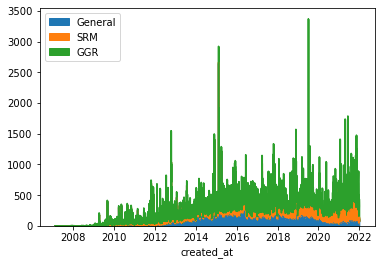

In [13]:
# group by day
# all
#daily_count = tweets_classified_df.groupby(by=tweets_classified_df['created_at'].dt.date)['tid'].count()
# by category
daily_count = tweets_classified_df.groupby(by=tweets_classified_df['created_at'].dt.date)[["General", "SRM", "GGR"]].sum()
daily_count.plot.area(stacked=True)

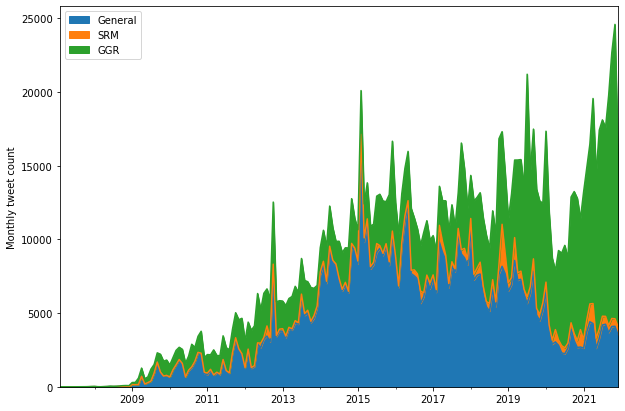

In [145]:
# group by month

fig, ax = plt.subplots(figsize=(10,7))
# by category
monthly_count = tweets_classified_df.groupby(pd.Grouper(key='created_at', freq='M'))[["General", "SRM", "GGR"]].sum()
monthly_count.plot.area(stacked=True, ax=ax)
#monthly_count.plot(ax=ax)
# all
#monthly_count = tweets_classified_df.groupby(pd.Grouper(key='created_at', freq='M'))['tid'].count()
#monthly_count.plot(ax=ax, color='k', label='total')
ax.set_ylabel('Monthly tweet count')
ax.set_xlabel('')
fig.savefig("figures/timeseries_monthly_category_stacked.png", **savefig_settings)

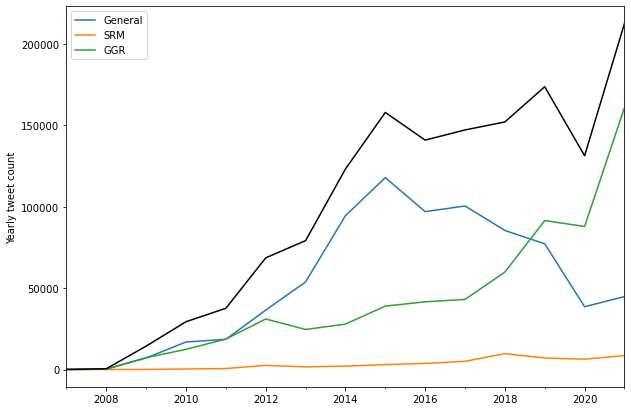

In [21]:
# group by year

fig, ax = plt.subplots(figsize=(10,7))
# by category
monthly_count = tweets_classified_df.groupby(pd.Grouper(key='created_at', freq='Y'))[["General", "SRM", "GGR"]].sum()
#monthly_count.plot.area(stacked=True, ax=ax)
monthly_count.plot(ax=ax)
# all
monthly_count = tweets_classified_df.groupby(pd.Grouper(key='created_at', freq='Y'))['tid'].count()
monthly_count.plot(ax=ax, color='k', label='total')
ax.set_ylabel('Yearly tweet count')
ax.set_xlabel('')
fig.savefig("figures/timeseries_yearly_category_line.png", **savefig_settings)

(0.0, 10000.0)

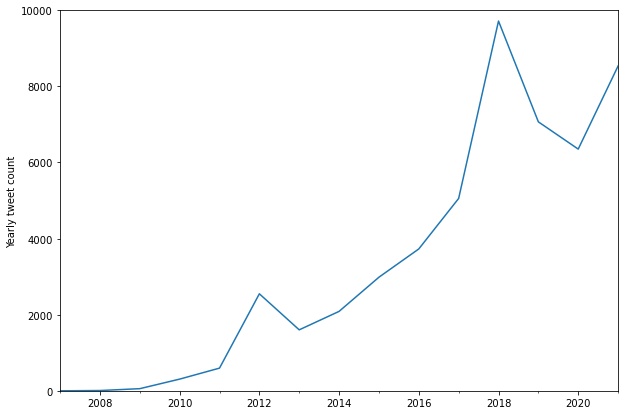

In [42]:
# group by year: only srm

fig, ax = plt.subplots(figsize=(10,7))
# by category
monthly_count = tweets_classified_df.groupby(pd.Grouper(key='created_at', freq='Y'))["SRM"].sum()
#monthly_count.plot.area(stacked=True, ax=ax)
monthly_count.plot(ax=ax)
ax.set_ylabel('Yearly tweet count')
ax.set_xlabel('')
ax.set_ylim([0,10000])

## plot tweet counts per technology_category over time

In [ ]:
# todo

# group by month and technology category

fig, ax = plt.subplots(figsize=(10,7))
# by category
monthly_count = plot_df.groupby(pd.Grouper(key='created_at', freq='M'))[["General", "SRM", "GGR"]].sum()
monthly_count.plot.area(stacked=True, ax=ax)
#monthly_count.plot(ax=ax)
# all
#monthly_count = tweets_classified_df.groupby(pd.Grouper(key='created_at', freq='M'))['tid'].count()
#monthly_count.plot(ax=ax, color='k', label='total')
ax.set_ylabel('Monthly tweet count')
ax.set_xlabel('')
fig.savefig("figures/timeseries_monthly_technology_category_stacked.png", **savefig_settings)

# plot labels over time

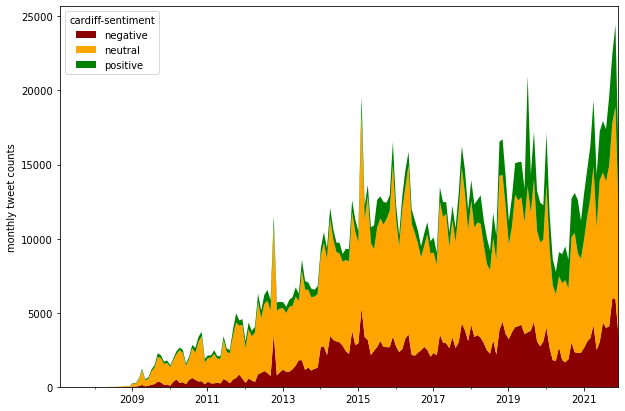

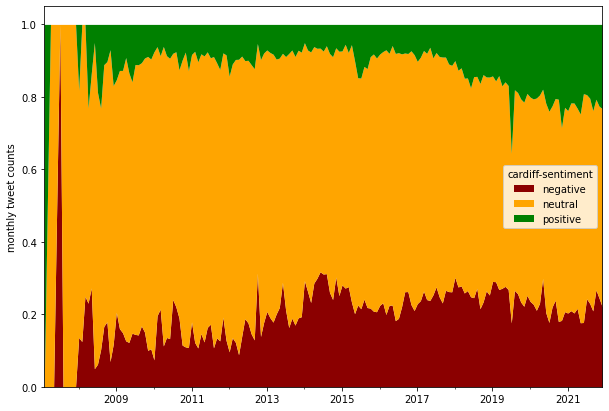

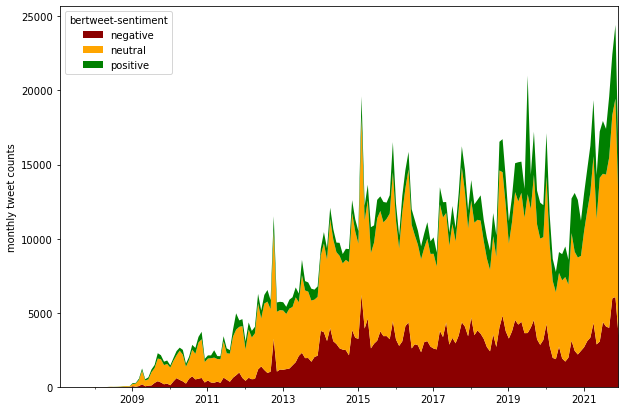

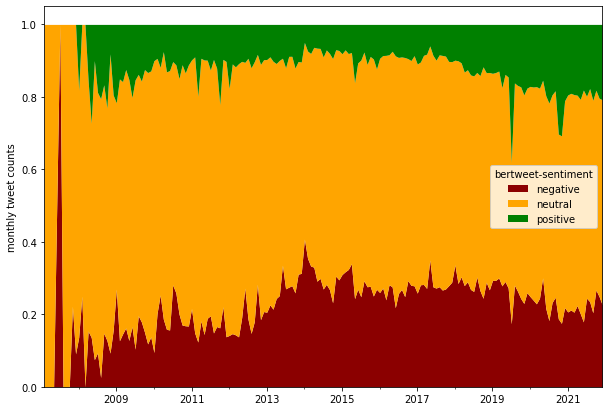

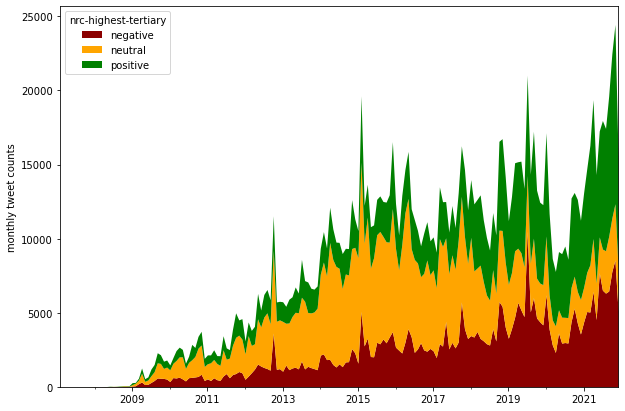

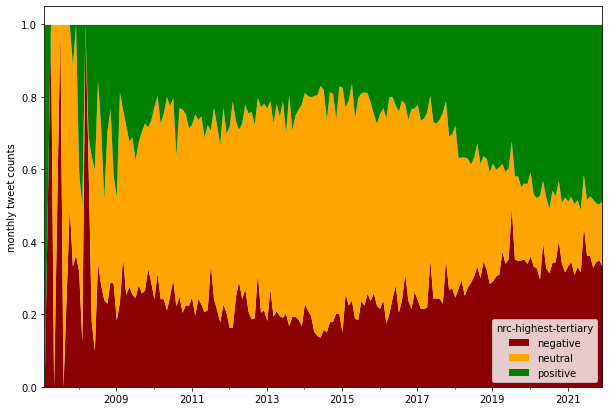

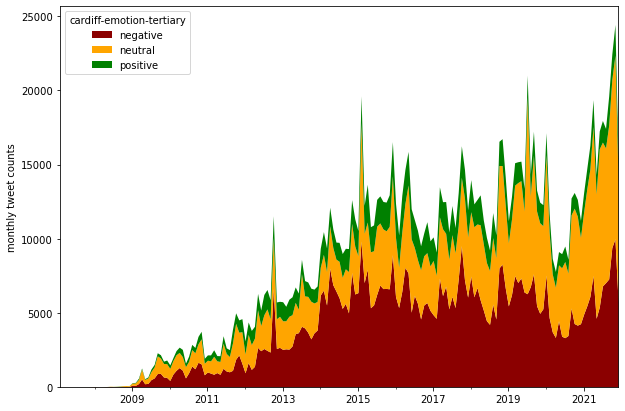

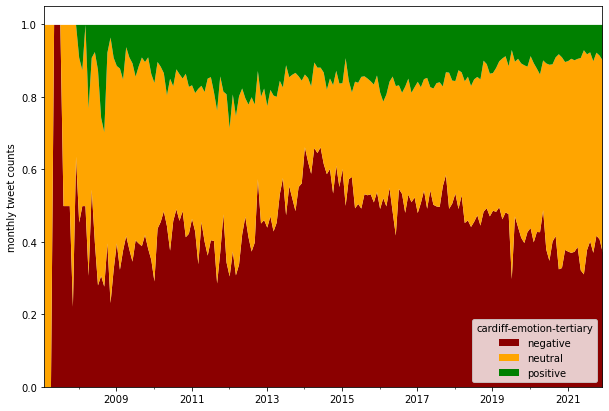

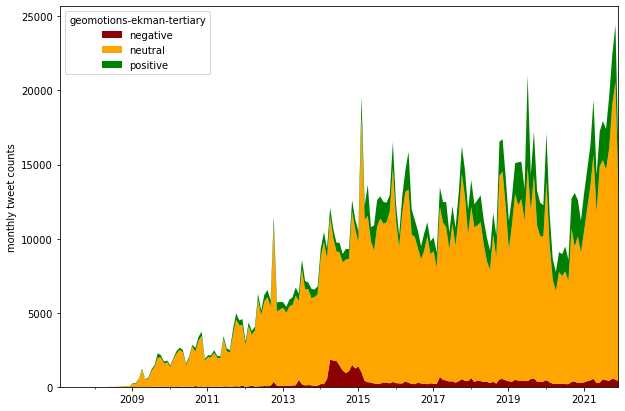

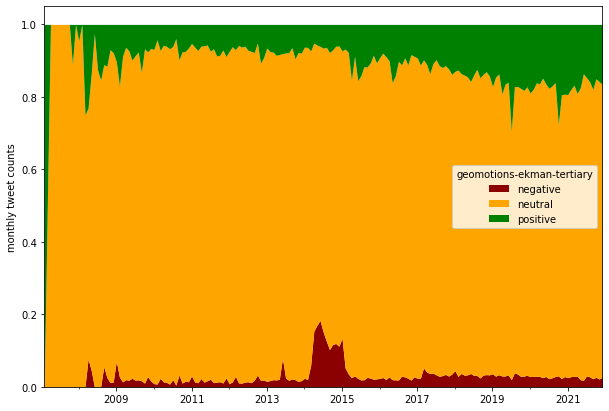

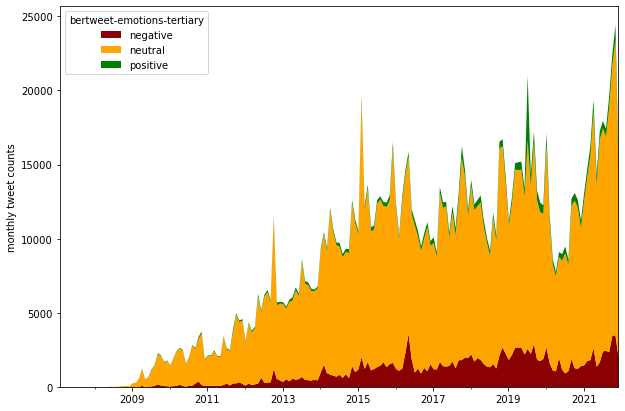

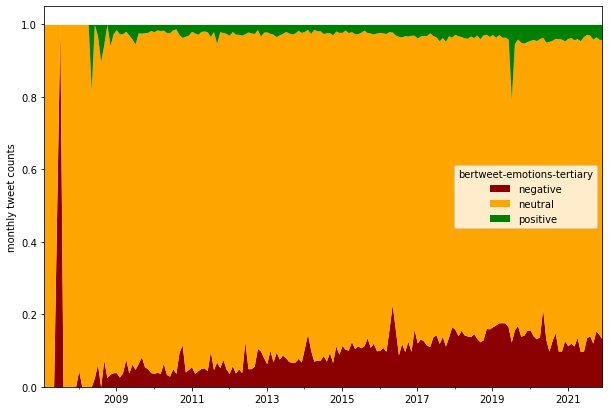

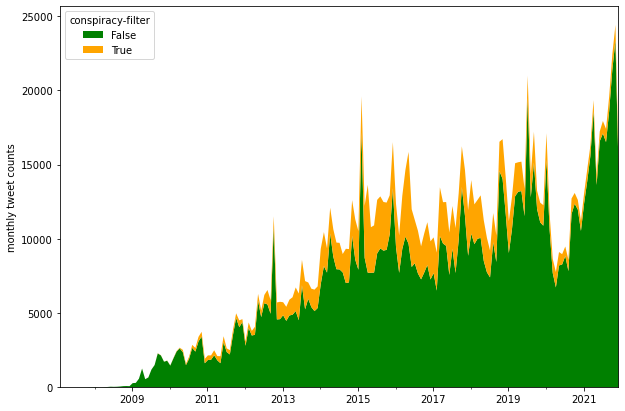

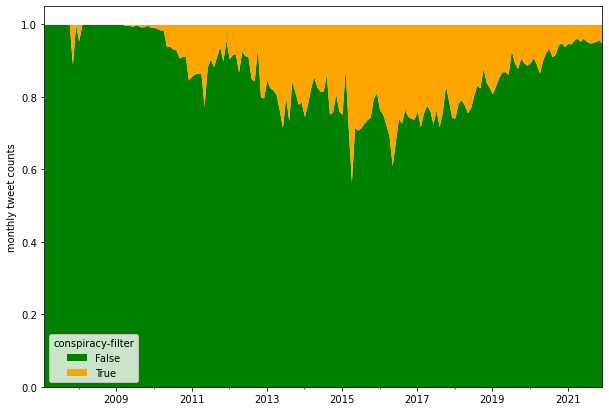

In [126]:
# plot share of negative/neutral/positive for different classifiers over time

tweets_classified_df['month'] = tweets_classified_df['created_at'].dt.to_period('M')

for classifier_name in ['cardiff-sentiment', 'bertweet-sentiment', 'nrc-highest-tertiary',
'cardiff-emotion-tertiary', 'geomotions-ekman-tertiary', 'bertweet-emotions-tertiary', 'conspiracy-filter']:
    
    classes_per_month = tweets_classified_df.groupby(['month', classifier_name]).size()
    classes_per_month = classes_per_month.unstack().fillna(0)
            
    if classifier_name == 'conspiracy-filter':
        color = ['g', 'orange']
    else:
        color = ['darkred', 'orange', 'g']
    
    fig, ax = plt.subplots(figsize=(10,7))
    classes_per_month.plot.area(color=color, ax=ax, linewidth=0)
    #classes_per_month.plot(color=color, ax=ax)   
    ax.set_ylabel("monthly tweet counts")
    ax.set_xlabel("")
    #fig.savefig("figures/timeseries_monthly_{}_stacked.png".format(classifier_name), **savefig_settings)
    
    shares_per_month = classes_per_month.divide(classes_per_month.sum(axis=1), axis=0)
        
    fig, ax = plt.subplots(figsize=(10,7))    
    shares_per_month.plot.area(color=color, ax=ax, linewidth=0)
    ax.set_ylabel("monthly tweet counts")
    ax.set_xlabel("")
    fig.savefig("figures/timeseries_monthly_shares_{}_stacked.png".format(classifier_name), **savefig_settings)
    

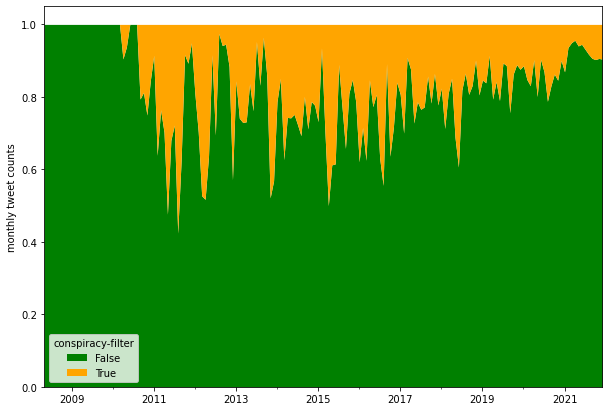

In [64]:
# plot share of conspiracy over time

tweets_classified_df['month'] = tweets_classified_df['created_at'].dt.to_period('M')

classifier_name  = 'conspiracy-filter'
category_label = "SRM" # General

classes_per_month = tweets_classified_df[tweets_classified_df[category_label] == 1].groupby(['month', classifier_name]).size()
classes_per_month = classes_per_month.unstack().fillna(0)

fig, ax = plt.subplots(figsize=(10,7))

color = ['g', 'orange']

shares_per_month = classes_per_month.divide(classes_per_month.sum(axis=1), axis=0)

#classes_per_month.plot.area(color=color, ax=ax, linewidth=0)
#classes_per_month.plot(color=color, ax=ax)
shares_per_month.plot.area(color=color, ax=ax, linewidth=0)


ax.set_ylabel("monthly tweet counts")
ax.set_xlabel("")
fig.savefig("figures/timeseries_monthly_shares_conspiracy-filter_{}_stacked.png".format(category_label), **savefig_settings)

conspiracy-filter     False      True
month                                
2007-08            1.000000  0.000000
2007-10            1.000000  0.000000
2007-11            0.875000  0.125000
2007-12            1.000000  0.000000
2008-01            0.916667  0.083333
...                     ...       ...
2021-08            0.804665  0.195335
2021-09            0.748505  0.251495
2021-10            0.759295  0.240705
2021-11            0.765164  0.234836
2021-12            0.791159  0.208841

[172 rows x 2 columns]

## look at data in jsonl file for details

In [31]:
tweets = []

with open("../classifier/tweets_classified2.jsonl", 'r') as f:
    i = 0
    
    for line in f.readlines():
        i += 1
        tweet = json.loads(line)
        tweets.append(tweet)
        
        if i > 1000:
            break

In [32]:
for tweet in tweets:
    #print(tweet['classes']['cardiff-sentiment'])
    em_dict = tweet['classes']['nrc']
    print(em_dict)
    key = max(em_dict, key=em_dict.get) if em_dict else None
    print(key)
    if key:
        print(em_dict[key])

{'fear': 0.07142857142857142, 'anger': 0.21428571428571427, 'negative': 0.21428571428571427, 'sadness': 0.21428571428571427, 'disgust': 0.21428571428571427, 'anticipation': 0.07142857142857142}
anger
0.21428571428571427
{}
None
{'positive': 1.0}
positive
1.0
{'fear': 0.07142857142857142, 'anger': 0.21428571428571427, 'negative': 0.21428571428571427, 'sadness': 0.21428571428571427, 'disgust': 0.21428571428571427, 'anticipation': 0.07142857142857142}
anger
0.21428571428571427
{'fear': 0.07142857142857142, 'anger': 0.21428571428571427, 'negative': 0.21428571428571427, 'sadness': 0.21428571428571427, 'disgust': 0.21428571428571427, 'anticipation': 0.07142857142857142}
anger
0.21428571428571427
{'positive': 1.0}
positive
1.0
{}
None
{}
None
{}
None
{'sadness': 1.0}
sadness
1.0
{}
None
{'anticipation': 1.0}
anticipation
1.0
{'fear': 0.5, 'anticipation': 0.5}
fear
0.5
{'anticipation': 1.0}
anticipation
1.0
{}
None
{}
None
{}
None
{'fear': 0.125, 'anger': 0.125, 'trust': 0.125, 'positive': 0.1

In [33]:
tweets[0]

{'referenced_tweets': [{'type': 'replied_to', 'id': '647550218771173376'}],
 'entities': {'urls': [{'start': 92,
    'end': 114,
    'url': 'http://t.co/65b0RLJrq4',
    'expanded_url': 'http://holmestead.ca/index-ct.html',
    'display_url': 'holmestead.ca/index-ct.html'},
   {'start': 116,
    'end': 138,
    'url': 'http://t.co/GcNqqhTfut',
    'expanded_url': 'http://www.agriculturedefensecoalition.org/content/weather-modification',
    'display_url': 'agriculturedefensecoalition.org/content/weathe…'}],
  'mentions': [{'start': 0,
    'end': 12,
    'username': 'lorabruncke',
    'id': '437673995'},
   {'start': 13, 'end': 17, 'username': 'WHO', 'id': '14499829'},
   {'start': 18, 'end': 31, 'username': 'OpChemtrails', 'id': '2783708485'},
   {'start': 33, 'end': 36, 'username': 'UN', 'id': '14159148'},
   {'start': 53, 'end': 64, 'username': 'Greenpeace', 'id': '3459051'}],
  'hashtags': [{'start': 42, 'end': 48, 'tag': 'COP21'},
   {'start': 76, 'end': 91, 'tag': 'Geoengineering'

In [ ]:
# from Tim's script

In [ ]:
import json
import re
from collections import defaultdict
from matplotlib import pyplot as plt
import numpy as np
#from tqdm import tqdm

In [ ]:
models = ['cardiff-stance-climate', 'cardiff-offensive',  # 'cards',
          'cardiff-sentiment', 'bertweet-sentiment',
          'geomotions-orig', 'geomotions-ekman', 'cardiff-emotion', 'bertweet-emotions', 'nrc']

stats = {
    model: defaultdict(int)
    for model in models
}
cooc_stats = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(int))))

FILE_TWEETS = '../classifier/tweets_classified2.jsonl'
FILE_OUT = '/tweets_classified_new.csv'

with open(FILE_TWEETS, 'r') as f_in: #, \
#        open(FILE_OUT, 'w') as f_out:
    #f_out.write(','.join(models) + ',text\n')
    li = 0
    for line in f_in:#tqdm(f_in):
        li += 1
        tweet = json.loads(line)
        for model in models:
            labels = list(tweet['classes'][model].keys())
            #f_out.write('|'.join(labels) + ',')
            for label in labels:
                stats[model][label] += 1

            for model_cooc in models:
                if model_cooc != model:
                    labels_cooc = list(tweet['classes'][model_cooc].keys())
                    for label_cooc in labels_cooc:
                        for label in labels:
                            cooc_stats[model][label][model_cooc][label_cooc] += 1
        #f_out.write(re.sub(r'(\s+|,)', ' ', tweet['text']) + '\n')
        if li > 1000:
             break

print(stats)

In [ ]:
cooc_stats

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

        ax = plt.subplot(3,3,idx)

        cm = confusion_matrix([t['annotations_sub'].get(u1, 'UNK') for t in tweet_map.values()],
                              [t['annotations_sub'].get(u2, 'UNK') for t in tweet_map.values()],
                             labels=sorted(['UNK']+[v[0] for v in cat_map_sub.values()]))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                      display_labels=sorted(['UNK']+[v[0] for v in cat_map_sub.values()]))
        #disp = ConfusionMatrixDisplay.from_predictions(
        #    y_pred=[t['annotations_sub'].get(u1, 'UNK') for t in tweet_map.values()],
        #    y_test=[t['annotations_sub'].get(u2, 'UNK') for t in tweet_map.values()],
        #    display_labels=sorted(['UNK']+[v[0] for v in cat_map_sub.values()]))
        
        disp.plot(ax=ax)
        disp.ax_.tick_params(axis='x', rotation=90)
        ax.set_xlabel(u2)
        ax.set_ylabel(u1)

In [ ]:
# print(json.dumps(stats, indent=3))
# print(json.dumps(cooc_stats, indent=3))
print('plotting')
fig = plt.figure(figsize=(40, 40), dpi=120)
spi = 0
for i, model_i in enumerate(models):
    for j, model_j in enumerate(models):
        spi += 1
        if model_j != model_i:

            plt.subplot(len(models), len(models), spi, xmargin=10, ymargin=10)
            labels_i = sorted(list(cooc_stats[model_i].keys()), reverse=True)
            labels_j = sorted(list(cooc_stats[model_j].keys()), reverse=True)
            if model_i == 'cards':
                labels_i.remove('0_0')
            x = np.zeros((len(labels_i), len(labels_j)))
            for li, label_i in enumerate(labels_i):
                for lj, label_j in enumerate(labels_j):
                    x[li][lj] = cooc_stats[model_i][label_i][model_j][label_j]

            plt.imshow(x, interpolation='none')
            plt.ylabel(model_i, rotation=90)
            plt.xlabel(model_j)
            plt.xticks(np.arange(len(labels_j)), labels_j, rotation=90, fontsize=6)
            plt.yticks(np.arange(len(labels_i)), labels_i, fontsize=6)

print('layout+show')
fig.tight_layout()
plt.show()